An implementation of expanded-ensemble (Wang-Landau) sampling in a simple harmonic bias system

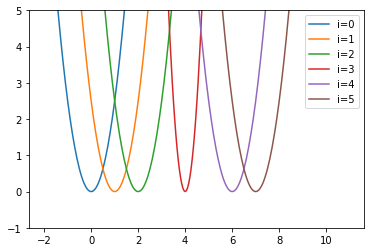

In [2]:
# let's define a number of harmonic potentials
#
#     u_i(x) = 1/2 * k_i (x - x_i)^2
#
# each with a different equilibrium position x_i and force constant k_i

import numpy as np

def u_i(x, k, x0):
    """Returns the (reduced) energy of the harmonic potential in units kT."""
    return 0.5*k*(x-x0)**2

x_i = np.array([0., 1., 2., 4., 6., 7.])   # length (unitless)
k_i = np.array([5.0, 5.0, 5.0, 20.0, 5.0, 5.0])  # kT/(length)^2
n_ensembles = len(x_i)


# Let's make a plot of these

from matplotlib import pyplot as plt

plt.figure()
xvalues = np.arange(-2., 11., 0.05)
for i in range(n_ensembles):
    plt.plot(xvalues, u_i(xvalues, k_i[i], x_i[i]), label='i=%d'%i)
plt.ylim(-1,5)
plt.legend(loc='best')
plt.show()


/Users/vv/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


exp_neg_f = 0.277793459757716 +/- 56.94534700246939
exp_neg_f_analytical 0.5
f_estimate = 1.2808773919278174 f = 0.6931471805599453


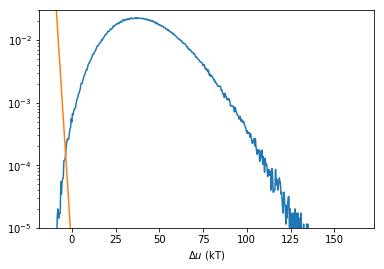

In [27]:
#### Draw a bunch of samples from P_i=2 and compute the corresponding $\Delta_u_{2 \rightarrow 3}*
nsamples = 1000000
x_2_samples = x_i[2] + np.random.randn(nsamples)/(k_i[2]**0.5)
# print('x_2_samples', x_2_samples)
Delta_u_23_samples = u_i(x_2_samples, k_i[3], x_i[3]) -  u_i(x_2_samples, k_i[2], x_i[2])
counts, bin_edges = np.histogram(Delta_u_23_samples, bins=500, normed=True)
bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0


plt.figure()
plt.plot(bin_centers, counts)
plt.plot(bin_centers, 4.0e-6*np.exp(-bin_centers), label='$\exp(-\Delta u)$')
plt.ylim(0.00001,0.03)
plt.yscale('log')
plt.xlabel('$\Delta u$ (kT)')
# compute the average of e^{-\Delta u} = e^{-f}
exp_neg_f = np.mean(np.exp(-1.0*Delta_u_23_samples))
exp_neg_f_std = np.std(np.exp(-1.0*Delta_u_23_samples))
print('exp_neg_f =', exp_neg_f, '+/-', exp_neg_f_std)
exp_neg_f_analytical = (k_i[2]/k_i[3])**0.5
print('exp_neg_f_analytical', exp_neg_f_analytical)
f_estimate = -1.0*np.log(exp_neg_f)
f = -1.0*np.log(exp_neg_f_analytical)
print('f_estimate =', f_estimate, 'f =', f)


In [8]:
# Wang-landau sampling

g = np.zeros(n_ensembles) # bias energies
h = np.zeros(n_ensembles) # histogram counts

wl_increment = 10.0    # in kT
wl_scaling  = 0.8
flatness = 0.95        # if all histogram values are within flatness*100
                       # percent of the mean counts, decr

wl_increment_freq = 10  # frequency to update wl sampling
                        # wl_increment and reset histogram

# random walk
x = 0.0   # initial position
dx = 0.1 # gaussian step size 
i = 0  # thermo index

# status output
print_every = 1000

# trajectory
traj_every = 10
x_traj = []
i_traj = []
step_traj = []
wl_increment_traj = []
free_energy_traj = []
dhdl_traj = []

energy = u_i(x, k_i[i], x_i[i])
nsteps = 1000000
for step in range(nsteps):
    
    # propose a MC move
    x_new = x + dx*np.random.randn()
    energy_new = u_i(x_new, k_i[i], x_i[i])
    
    # and accept it according to the metropolis criterion
    accept = False
    P_accept = min(1., np.exp(-(energy_new - energy)))
    if np.random.rand() < P_accept:
        accept = True
    
    if accept:
        x = x_new
        energy = energy_new
    
    
    # update the WL sampling
    if (step%wl_increment_freq == 0):
        
        g[i] += wl_increment
        h[i] += 1.0
        
        # reset the bias to i=0 reference
        g -= g[0]
        
        # attempt a move to a neighboring ensemble
        wl_accept = False
        if np.random.rand() < 0.5:
            j = i+1
        else:
            j = i-1
        
        if (j >= 0) and (j < n_ensembles):
            P_wl_accept = min(1., np.exp(-(u_i(x, k_i[j], x_i[j]) + g[j] - u_i(x, k_i[i], x_i[i]) - g[i])))
            if np.random.rand() < P_wl_accept:
                wl_accept = True    
        if wl_accept:
            i = j
            
        # check if the histogram is flat enough
        mean_counts = h.mean()
        
        which_are_flat_enough = (h > flatness*mean_counts)*(h < (2.0-flatness)*mean_counts)
        if step%print_every == 0:
            print('h', h, 'mean_counts', mean_counts)
            print('which_are_flat_enough', which_are_flat_enough)
        
        if np.sum( which_are_flat_enough.astype(int) ) == n_ensembles:
            wl_increment *= wl_scaling
            h = np.zeros(n_ensembles)

    # print a status report
    if step%print_every == 0:
        print('x', x, 'thermo index', i, 'wl_increment =', wl_increment, 'kT')
        print()
        print('# ensemble\thistogram\tg (kT)')
        for k in range(n_ensembles):
            outstr = '%8d\t%8d\t%3.4f'%(k, h[k], g[k])
            if k == i:
                outstr += ' <<'
            print(outstr)

    # store sample in trajectory 
    if step%traj_every == 0:
        x_traj.append(x)
        i_traj.append(i)
        step_traj.append(step)
        free_energy_traj.append(-1.0*g[-1])
        wl_increment_traj.append(wl_increment)

        # store delta energies of all thermo indices 
        dhdl_traj.append( [u_i(x, k_i[j], x_i[j]) - u_i(x, k_i[i], x_i[i]) for j in range(n_ensembles)]  )
        

h [1. 0. 0. 0. 0. 0.] mean_counts 0.16666666666666666
which_are_flat_enough [False False False False False False]
x -0.08287229454572059 thermo index 1 wl_increment = 10.0 kT

# ensemble	histogram	g (kT)
       0	       1	0.0000
       1	       0	-10.0000 <<
       2	       0	-10.0000
       3	       0	-10.0000
       4	       0	-10.0000
       5	       0	-10.0000
h [25. 23. 23.  5. 14. 11.] mean_counts 16.833333333333332
which_are_flat_enough [False False False False False False]
x -0.30913138314324595 thermo index 4 wl_increment = 10.0 kT

# ensemble	histogram	g (kT)
       0	      25	0.0000
       1	      23	-20.0000
       2	      23	-20.0000
       3	       5	-200.0000
       4	      14	-110.0000 <<
       5	      11	-140.0000
h [37. 37. 40. 23. 33. 31.] mean_counts 33.5
which_are_flat_enough [False False False False  True False]
x -0.5522834101642736 thermo index 0 wl_increment = 10.0 kT

# ensemble	histogram	g (kT)
       0	      37	0.0000 <<
       1	      37	0.0000
       2	  

h [20. 10. 12.  2.  0.  0.] mean_counts 7.333333333333333
which_are_flat_enough [False False False False False False]
x 1.3057076201643345 thermo index 3 wl_increment = 1.6777216000000008 kT

# ensemble	histogram	g (kT)
       0	      20	0.0000
       1	      10	-6.7304
       2	      12	-8.0756
       3	       2	-85.9080 <<
       4	       0	-89.9432
       5	       0	-111.6261
h [20. 14. 18. 32. 30. 30.] mean_counts 24.0
which_are_flat_enough [False False False False False False]
x 2.0253563269695016 thermo index 2 wl_increment = 1.6777216000000008 kT

# ensemble	histogram	g (kT)
       0	      20	0.0000
       1	      14	-0.0195
       2	      18	1.9907 <<
       3	      32	-35.5764
       4	      30	-39.6115
       5	      30	-61.2945
h [30. 29. 32. 55. 49. 49.] mean_counts 40.666666666666664
which_are_flat_enough [False False False False False False]
x 2.1288366187781835 thermo index 0 wl_increment = 1.6777216000000008 kT

# ensemble	histogram	g (kT)
       0	      30	0.0000 <<
  

h [70. 67. 66. 98. 97. 99.] mean_counts 82.83333333333333
which_are_flat_enough [False False False False False False]
x 2.4413398745763475 thermo index 4 wl_increment = 0.8589934592000005 kT

# ensemble	histogram	g (kT)
       0	      70	0.0000
       1	      67	1.0274
       2	      66	0.9707
       3	      98	-22.1278
       4	      97	-30.1089 <<
       5	      99	-50.6107
h [ 96.  88.  86. 104. 110. 113.] mean_counts 99.5
which_are_flat_enough [ True False False  True False False]
x 2.0864457811076296 thermo index 5 wl_increment = 0.8589934592000005 kT

# ensemble	histogram	g (kT)
       0	      96	0.0000
       1	      88	-3.2676
       2	      86	-4.1833
       3	     104	-39.3076
       4	     110	-41.2758
       5	     113	-60.9187 <<
h [ 96.  94.  98. 138. 134. 137.] mean_counts 116.16666666666667
which_are_flat_enough [False False False False False False]
x 2.9162763177545274 thermo index 5 wl_increment = 0.8589934592000005 kT

# ensemble	histogram	g (kT)
       0	      96	0.

h [212. 250. 290. 353. 435. 468.] mean_counts 334.6666666666667
which_are_flat_enough [False False False False False False]
x 6.002263479433472 thermo index 0 wl_increment = 0.6871947673600004 kT

# ensemble	histogram	g (kT)
       0	     212	0.0000 <<
       1	     250	27.1408
       2	     290	47.6999
       3	     353	49.8559
       4	     435	93.0708
       5	     468	96.1053
h [230. 267. 311. 381. 448. 471.] mean_counts 351.3333333333333
which_are_flat_enough [False False False False False False]
x 5.637554774676428 thermo index 1 wl_increment = 0.6871947673600004 kT

# ensemble	histogram	g (kT)
       0	     230	0.0000
       1	     267	26.4536 <<
       2	     311	49.7615
       3	     381	56.7278
       4	     448	89.6348
       5	     471	85.7974
h [255. 290. 329. 398. 454. 482.] mean_counts 368.0
which_are_flat_enough [False False False False False False]
x 6.53207093996541 thermo index 5 wl_increment = 0.6871947673600004 kT

# ensemble	histogram	g (kT)
       0	     255	0.00

h [29. 13.  5.  0.  0.  0.] mean_counts 7.833333333333333
which_are_flat_enough [False False False False False False]
x 1.2975313052651376 thermo index 2 wl_increment = 0.4398046511104003 kT

# ensemble	histogram	g (kT)
       0	      29	0.0000
       1	      13	-1.8863
       2	       5	-4.2245 <<
       3	       0	-31.8928
       4	       0	-42.9663
       5	       0	-64.3959
h [29. 23. 28. 14. 27. 26.] mean_counts 24.5
which_are_flat_enough [False False False False False False]
x 2.3021506541072747 thermo index 5 wl_increment = 0.4398046511104003 kT

# ensemble	histogram	g (kT)
       0	      29	0.0000
       1	      23	2.5118
       2	      28	5.8910
       3	      14	-25.7356
       4	      27	-31.0916
       5	      26	-52.9609 <<
h [31. 31. 39. 41. 50. 55.] mean_counts 41.166666666666664
which_are_flat_enough [False False False  True False False]
x 1.9201353877173561 thermo index 1 wl_increment = 0.4398046511104003 kT

# ensemble	histogram	g (kT)
       0	      31	0.0000
       

h [284. 323. 360. 443. 500. 537.] mean_counts 407.8333333333333
which_are_flat_enough [False False False False False False]
x 4.981216415141669 thermo index 1 wl_increment = 0.4398046511104003 kT

# ensemble	histogram	g (kT)
       0	     284	0.0000
       1	     323	22.3030 <<
       2	     360	39.7560
       3	     443	50.7905
       4	     500	64.7858
       5	     537	59.6291
h [293. 332. 368. 455. 527. 572.] mean_counts 424.5
which_are_flat_enough [False False False False False False]
x 4.358386181784027 thermo index 3 wl_increment = 0.4398046511104003 kT

# ensemble	histogram	g (kT)
       0	     293	0.0000
       1	     332	22.3030
       2	     368	39.3161
       3	     455	52.1099 <<
       4	     527	72.7023
       5	     572	71.0640
h [337. 363. 385. 463. 527. 572.] mean_counts 441.1666666666667
which_are_flat_enough [False False False  True False False]
x 3.8424384899682393 thermo index 2 wl_increment = 0.4398046511104003 kT

# ensemble	histogram	g (kT)
       0	     337	0.

h [131. 143. 195. 291. 394. 424.] mean_counts 263.0
which_are_flat_enough [False False False False False False]
x 6.986171573233528 thermo index 4 wl_increment = 0.3518437208883203 kT

# ensemble	histogram	g (kT)
       0	     131	0.0000
       1	     143	8.4931
       2	     195	28.8488
       3	     291	36.2769
       4	     394	64.9617 <<
       5	     424	65.9622
h [131. 162. 213. 316. 416. 440.] mean_counts 279.6666666666667
which_are_flat_enough [False False False False False False]
x 5.326974502909924 thermo index 2 wl_increment = 0.3518437208883203 kT

# ensemble	histogram	g (kT)
       0	     131	0.0000
       1	     162	15.1781
       2	     213	35.1820 <<
       3	     316	45.0730
       4	     416	72.7023
       5	     440	71.5917
h [140. 194. 242. 346. 416. 440.] mean_counts 296.3333333333333
which_are_flat_enough [False False False False False False]
x 5.326974502909924 thermo index 3 wl_increment = 0.3518437208883203 kT

# ensemble	histogram	g (kT)
       0	     140	0.00

h [565. 601. 629. 735. 760. 788.] mean_counts 679.6666666666666
which_are_flat_enough [False False False False False False]
x 7.26621688701052 thermo index 5 wl_increment = 0.3518437208883203 kT

# ensemble	histogram	g (kT)
       0	     565	0.0000
       1	     601	16.9373
       2	     629	28.8488
       3	     735	39.7953
       4	     760	41.0364
       5	     788	41.3332 <<
h [565. 601. 629. 735. 807. 841.] mean_counts 696.3333333333334
which_are_flat_enough [False False False False False False]
x 6.175407363537234 thermo index 4 wl_increment = 0.3518437208883203 kT

# ensemble	histogram	g (kT)
       0	     565	0.0000
       1	     601	16.9373
       2	     629	28.8488
       3	     735	39.7953
       4	     807	57.5730 <<
       5	     841	59.9809
h [565. 603. 650. 755. 840. 865.] mean_counts 713.0
which_are_flat_enough [False False False False False False]
x 7.362256943146813 thermo index 5 wl_increment = 0.3518437208883203 kT

# ensemble	histogram	g (kT)
       0	     565	0.00

h [40. 25. 13.  0.  0.  0.] mean_counts 13.0
which_are_flat_enough [False False  True False False False]
x 2.2532901460092067 thermo index 2 wl_increment = 0.28147497671065624 kT

# ensemble	histogram	g (kT)
       0	      40	0.0000
       1	      25	-0.3030
       2	      13	-1.2690 <<
       3	       0	-3.8333
       4	       0	-11.3883
       5	       0	-14.9618
h [62. 48. 51. 13.  4.  0.] mean_counts 29.666666666666668
which_are_flat_enough [False False False False False False]
x 2.9771326490951786 thermo index 3 wl_increment = 0.28147497671065624 kT

# ensemble	histogram	g (kT)
       0	      62	0.0000
       1	      48	-0.0215
       2	      51	3.2346
       3	      13	-6.3666 <<
       4	       4	-16.4549
       5	       0	-21.1543
h [62. 48. 51. 36. 40. 41.] mean_counts 46.333333333333336
which_are_flat_enough [False  True False False False False]
x 7.139642020853628 thermo index 5 wl_increment = 0.28147497671065624 kT

# ensemble	histogram	g (kT)
       0	      62	0.0000
     

h [503. 483. 461. 402. 391. 338.] mean_counts 429.6666666666667
which_are_flat_enough [False False False False False False]
x -0.2636569618994594 thermo index 0 wl_increment = 0.28147497671065624 kT

# ensemble	histogram	g (kT)
       0	     503	0.0000 <<
       1	     483	-1.7104
       2	     461	-5.4912
       3	     402	-21.0033
       4	     391	-31.6545
       5	     338	-50.1462
h [507. 489. 494. 418. 413. 357.] mean_counts 446.3333333333333
which_are_flat_enough [False False False False False False]
x 2.608831607316774 thermo index 5 wl_increment = 0.28147497671065624 kT

# ensemble	histogram	g (kT)
       0	     507	0.0000
       1	     489	-1.1474
       2	     494	2.6716
       3	     418	-17.6256
       4	     413	-26.5880
       5	     357	-45.9241 <<
h [550. 521. 503. 421. 418. 365.] mean_counts 463.0
which_are_flat_enough [False False False False False False]
x -0.690909849164697 thermo index 1 wl_increment = 0.28147497671065624 kT

# ensemble	histogram	g (kT)
       0	 

h [951. 935. 916. 779. 782. 715.] mean_counts 846.3333333333334
which_are_flat_enough [False False False False False False]
x 2.328351514874356 thermo index 3 wl_increment = 0.28147497671065624 kT

# ensemble	histogram	g (kT)
       0	     951	0.0000
       1	     935	-0.5845
       2	     916	-3.5208
       3	     779	-40.9880 <<
       4	     782	-47.6986
       5	     715	-70.1309
h [951. 935. 916. 809. 815. 752.] mean_counts 863.0
which_are_flat_enough [False False False False False False]
x 2.328351514874356 thermo index 4 wl_increment = 0.28147497671065624 kT

# ensemble	histogram	g (kT)
       0	     951	0.0000
       1	     935	-0.5845
       2	     916	-3.5208
       3	     809	-32.5437
       4	     815	-38.4099 <<
       5	     752	-59.7163
h [972. 954. 942. 821. 827. 762.] mean_counts 879.6666666666666
which_are_flat_enough [False False False False False False]
x 2.3310926231228057 thermo index 4 wl_increment = 0.28147497671065624 kT

# ensemble	histogram	g (kT)
       0	  

h [  0.   0.   0.  65. 226. 268.] mean_counts 93.16666666666667
which_are_flat_enough [False False False False False False]
x 5.482910968327971 thermo index 3 wl_increment = 0.22517998136852502 kT

# ensemble	histogram	g (kT)
       0	       0	0.0000
       1	       0	2.2303
       2	       0	4.3605
       3	      65	7.4257 <<
       4	     226	31.9025
       5	     268	29.9053
h [  0.   0.  23. 121. 239. 276.] mean_counts 109.83333333333333
which_are_flat_enough [False False False False False False]
x 5.790845932614703 thermo index 4 wl_increment = 0.22517998136852502 kT

# ensemble	histogram	g (kT)
       0	       0	0.0000
       1	       0	2.2303
       2	      23	9.5396
       3	     121	20.0358
       4	     239	34.8298 <<
       5	     276	31.7067
h [  0.   0.  46. 141. 268. 304.] mean_counts 126.5
which_are_flat_enough [False False False False False False]
x 6.090897093533748 thermo index 5 wl_increment = 0.22517998136852502 kT

# ensemble	histogram	g (kT)
       0	       0	0.00

h [528. 513. 483. 437. 443. 455.] mean_counts 476.5
which_are_flat_enough [False False  True False False  True]
x 0.18343810604789634 thermo index 0 wl_increment = 0.22517998136852502 kT

# ensemble	histogram	g (kT)
       0	     528	0.0000 <<
       1	     513	-1.1474
       2	     483	-5.7726
       3	     437	-27.7024
       4	     443	-38.1285
       5	     455	-46.8811
h [541. 544. 538. 438. 443. 455.] mean_counts 493.1666666666667
which_are_flat_enough [False False False False False False]
x 0.8354655959233366 thermo index 0 wl_increment = 0.22517998136852502 kT

# ensemble	histogram	g (kT)
       0	     541	0.0000 <<
       1	     544	2.9058
       2	     538	3.6849
       3	     438	-30.4045
       4	     443	-41.0558
       5	     455	-49.8084
h [583. 578. 562. 438. 443. 455.] mean_counts 509.8333333333333
which_are_flat_enough [False False False False False False]
x 2.11624266458801 thermo index 3 wl_increment = 0.22517998136852502 kT

# ensemble	histogram	g (kT)
       0	   

h [117. 114. 106.  55.  70.  56.] mean_counts 86.33333333333333
which_are_flat_enough [False False False False False False]
x 2.609352672280431 thermo index 3 wl_increment = 0.14411518807585602 kT

# ensemble	histogram	g (kT)
       0	     117	0.0000
       1	     114	-0.1836
       2	     106	-0.8277
       3	      55	-23.2618 <<
       4	      70	-32.6071
       5	      56	-52.0242
h [120. 128. 127.  68.  95.  80.] mean_counts 103.0
which_are_flat_enough [False False False False False False]
x 0.8045626598526436 thermo index 0 wl_increment = 0.14411518807585602 kT

# ensemble	histogram	g (kT)
       0	     120	0.0000 <<
       1	     128	1.4016
       2	     127	1.7664
       3	      68	-21.8207
       4	      95	-29.4365
       5	      80	-48.9978
h [165. 159. 151.  68.  95.  80.] mean_counts 119.66666666666667
which_are_flat_enough [False False False False False False]
x 1.5087900667283167 thermo index 2 wl_increment = 0.14411518807585602 kT

# ensemble	histogram	g (kT)
       0	  

h [334. 325. 326. 262. 285. 265.] mean_counts 299.5
which_are_flat_enough [False False False False  True False]
x 0.7995657571433932 thermo index 1 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	g (kT)
       0	     334	0.0000
       1	     325	-1.5095 <<
       2	     326	-2.1824
       3	     262	-23.7806
       4	     285	-33.3565
       5	     265	-53.3500
h [353. 338. 350. 266. 287. 303.] mean_counts 316.1666666666667
which_are_flat_enough [False False False False False  True]
x 4.462003384625109 thermo index 5 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	g (kT)
       0	     353	0.0000
       1	     338	-2.2013
       2	     350	-1.6059
       3	     266	-25.5100
       4	     287	-35.3164
       5	     303	-51.1595 <<
h [353. 338. 350. 266. 290. 400.] mean_counts 332.8333333333333
which_are_flat_enough [False  True False False False False]
x 6.534250884304517 thermo index 5 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	g (kT)
       0	  

h [ 512.  529.  541.  730.  966. 1119.] mean_counts 732.8333333333334
which_are_flat_enough [False False False  True False False]
x 0.3388334258461787 thermo index 0 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	g (kT)
       0	     512	0.0000 <<
       1	     529	1.4881
       2	     541	2.0835
       3	     730	9.6541
       4	     966	24.6355
       5	    1119	24.5874
h [ 552.  568.  562.  730.  966. 1119.] mean_counts 749.5
which_are_flat_enough [False False False  True False False]
x 0.5086488240944641 thermo index 0 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	g (kT)
       0	     552	0.0000 <<
       1	     568	1.3728
       2	     562	-0.1071
       3	     730	5.0424
       4	     966	20.0238
       5	    1119	19.9758
h [ 599.  584.  599.  730.  966. 1119.] mean_counts 766.1666666666666
which_are_flat_enough [False False False  True False False]
x 1.9629620940797623 thermo index 1 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	g (kT)
  

h [1066. 1087. 1105.  972. 1151. 1316.] mean_counts 1116.1666666666667
which_are_flat_enough [ True  True  True False  True False]
x 1.2894507775293484 thermo index 1 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	g (kT)
       0	    1066	0.0000
       1	    1087	1.9493 <<
       2	    1105	3.2364
       3	     972	-26.3171
       4	    1151	-17.9073
       5	    1316	-16.5719
h [1118. 1126. 1114.  972. 1151. 1316.] mean_counts 1132.8333333333333
which_are_flat_enough [ True  True  True False  True False]
x 1.102837100352449 thermo index 2 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	g (kT)
       0	    1118	0.0000
       1	    1126	0.4505
       2	    1114	-1.7212 <<
       3	     972	-32.3122
       4	    1151	-23.9025
       5	    1316	-22.5670
h [1118. 1126. 1141. 1045. 1151. 1316.] mean_counts 1149.5
which_are_flat_enough [ True  True  True False  True False]
x 2.792068043656483 thermo index 3 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	

h [1472. 1479. 1483. 1455. 1526. 1682.] mean_counts 1516.1666666666667
which_are_flat_enough [ True  True  True  True  True False]
x -0.14790090441968706 thermo index 0 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	g (kT)
       0	    1472	0.0000 <<
       1	    1479	0.3352
       2	    1483	0.0082
       3	    1455	-17.4396
       4	    1526	-21.4814
       5	    1682	-21.1835
h [1506. 1517. 1511. 1455. 1526. 1682.] mean_counts 1532.8333333333333
which_are_flat_enough [ True  True  True False  True False]
x 0.5392650815064997 thermo index 0 wl_increment = 0.11529215046068482 kT

# ensemble	histogram	g (kT)
       0	    1506	0.0000 <<
       1	    1517	0.7963
       2	    1511	-0.6836
       3	    1455	-21.3595
       4	    1526	-25.4013
       5	    1682	-25.1035
h [1531. 1542. 1551. 1465. 1526. 1682.] mean_counts 1549.5
which_are_flat_enough [ True  True  True False  True False]
x 2.8714308824126658 thermo index 3 wl_increment = 0.11529215046068482 kT

# ensemble	histog

h [218. 228. 215. 370. 411. 443.] mean_counts 314.1666666666667
which_are_flat_enough [False False False False False False]
x 1.3185146897492517 thermo index 2 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
       0	     218	0.0000
       1	     228	0.3352
       2	     215	-1.0756 <<
       3	     370	-3.1894
       4	     411	-10.8284
       5	     443	-14.0354
h [248. 259. 254. 370. 411. 443.] mean_counts 330.8333333333333
which_are_flat_enough [False False False False False False]
x 0.6936872110883494 thermo index 0 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
       0	     248	0.0000 <<
       1	     259	0.4274
       2	     254	-0.2454
       3	     370	-5.9565
       4	     411	-13.5954
       5	     443	-16.8024
h [285. 288. 288. 370. 411. 443.] mean_counts 347.5
which_are_flat_enough [False False False False False False]
x 0.07481435575584465 thermo index 0 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
       0	   

h [506. 494. 484. 680. 923. 998.] mean_counts 680.8333333333334
which_are_flat_enough [False False False  True False False]
x 6.269840795892967 thermo index 4 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
       0	     506	0.0000
       1	     494	-1.6940
       2	     484	-2.8280
       3	     680	-1.1603
       4	     923	9.8320 <<
       5	     998	10.5910
h [ 506.  494.  484.  680.  977. 1044.] mean_counts 697.5
which_are_flat_enough [False False False  True False False]
x 5.813644907163928 thermo index 4 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
       0	     506	0.0000
       1	     494	-1.6940
       2	     484	-2.8280
       3	     680	-1.1603
       4	     977	14.8126 <<
       5	    1044	14.8337
h [ 506.  494.  484.  680. 1029. 1092.] mean_counts 714.1666666666666
which_are_flat_enough [False False False  True False False]
x 6.637293718888793 thermo index 5 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
       

h [ 841.  849.  851. 1002. 1428. 1514.] mean_counts 1080.8333333333333
which_are_flat_enough [False False False False False False]
x 6.072782937056331 thermo index 4 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
       0	     841	0.0000
       1	     849	0.1507
       2	     851	0.1235
       3	    1002	-2.3593
       4	    1428	25.5117 <<
       5	    1514	27.2853
h [ 841.  849.  851. 1080. 1449. 1515.] mean_counts 1097.5
which_are_flat_enough [False False False  True False False]
x 5.321556786270584 thermo index 3 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
       0	     841	0.0000
       1	     849	0.1507
       2	     851	0.1235
       3	    1080	4.8349 <<
       4	    1449	27.4486
       5	    1515	27.3775
h [ 841.  849.  855. 1134. 1467. 1539.] mean_counts 1114.1666666666667
which_are_flat_enough [False False False  True False False]
x 7.246241010312716 thermo index 5 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
  

h [1349. 1335. 1361. 1408. 1582. 1650.] mean_counts 1447.5
which_are_flat_enough [False False False  True False False]
x 7.203478181097885 thermo index 5 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
       0	    1349	0.0000
       1	    1335	-1.8784
       2	    1361	0.3080
       3	    1408	-11.7672
       4	    1582	-7.1390
       5	    1650	-7.0257 <<
h [1349. 1335. 1361. 1408. 1627. 1705.] mean_counts 1464.1666666666667
which_are_flat_enough [False False False  True False False]
x 7.535875875993273 thermo index 5 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (kT)
       0	    1349	0.0000
       1	    1335	-1.8784
       2	    1361	0.3080
       3	    1408	-11.7672
       4	    1627	-2.9885
       5	    1705	-1.9528 <<
h [1349. 1335. 1361. 1408. 1674. 1758.] mean_counts 1480.8333333333333
which_are_flat_enough [False False False  True False False]
x 6.350301693088407 thermo index 4 wl_increment = 0.09223372036854786 kT

# ensemble	histogram	g (k

h [  0.   0.   0. 214. 196. 199.] mean_counts 101.5
which_are_flat_enough [False False False False False False]
x 6.746202236325484 thermo index 4 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       0	       0	0.0000
       1	       0	0.4274
       2	       0	-0.1532
       3	     214	-9.6274
       4	     196	-14.9051 <<
       5	     199	-13.9247
h [  0.   0.   0. 214. 252. 243.] mean_counts 118.16666666666667
which_are_flat_enough [False False False False False False]
x 5.956620556421632 thermo index 4 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       0	       0	0.0000
       1	       0	0.4274
       2	       0	-0.1532
       3	     214	-9.6274
       4	     252	-10.7730 <<
       5	     243	-10.6781
h [  0.   0.   0. 214. 299. 296.] mean_counts 134.83333333333334
which_are_flat_enough [False False False False False False]
x 6.984852467596818 thermo index 5 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       0	       0

h [ 58. 140. 267. 708. 987. 949.] mean_counts 518.1666666666666
which_are_flat_enough [False False False False False False]
x 0.21153005545891218 thermo index 0 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       0	      58	0.0000 <<
       1	     140	6.4779
       2	     267	15.2683
       3	     708	22.5438
       4	     987	39.1808
       5	     949	37.1358
h [153. 145. 267. 708. 987. 949.] mean_counts 534.8333333333334
which_are_flat_enough [False False False False False False]
x 0.6940166631233889 thermo index 1 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       0	     153	0.0000
       1	     145	-0.1629 <<
       2	     267	8.2585
       3	     708	15.5340
       4	     987	32.1710
       5	     949	30.1261
h [201. 197. 267. 708. 987. 949.] mean_counts 551.5
which_are_flat_enough [False False False False False False]
x 1.062992076423496 thermo index 1 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       0	     201	0.

h [ 499.  508.  592. 1062. 1375. 1373.] mean_counts 901.5
which_are_flat_enough [False False False False False False]
x 6.325712781119348 thermo index 4 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       0	     499	0.0000
       1	     508	1.0915
       2	     592	6.7090
       3	    1062	16.1243
       4	    1375	35.2700 <<
       5	    1373	35.8815
h [ 499.  508.  593. 1070. 1423. 1416.] mean_counts 918.1666666666666
which_are_flat_enough [False False False False False False]
x 5.248215913139933 thermo index 3 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       0	     499	0.0000
       1	     508	1.0915
       2	     593	6.7828
       3	    1070	16.7146 <<
       4	    1423	38.8118
       5	    1416	39.0543
h [ 499.  508.  637. 1126. 1423. 1416.] mean_counts 934.8333333333334
which_are_flat_enough [False False False False False False]
x 5.248215913139933 thermo index 3 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       

h [1059. 1061. 1082. 1504. 1505. 1498.] mean_counts 1284.8333333333333
which_are_flat_enough [False False False False False False]
x 3.4711286190548463 thermo index 2 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       0	    1059	0.0000
       1	    1061	0.5750
       2	    1082	1.5439 <<
       3	    1504	7.4174
       4	    1505	3.5416
       5	    1498	3.7841
h [1106. 1092. 1104. 1504. 1505. 1498.] mean_counts 1301.5
which_are_flat_enough [False False False False False False]
x 0.8103408280185636 thermo index 1 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
       0	    1106	0.0000
       1	    1092	-0.6056 <<
       2	    1104	-0.3008
       3	    1504	3.9494
       4	    1505	0.0737
       5	    1498	0.3161
h [1139. 1117. 1146. 1504. 1505. 1498.] mean_counts 1318.1666666666667
which_are_flat_enough [False False False False False False]
x 0.33935317963350464 thermo index 1 wl_increment = 0.0737869762948383 kT

# ensemble	histogram	g (kT)
    

h [299. 311. 308. 296. 180.   0.] mean_counts 232.33333333333334
which_are_flat_enough [False False False False False False]
x 0.028429166170694298 thermo index 0 wl_increment = 0.05902958103587064 kT

# ensemble	histogram	g (kT)
       0	     299	0.0000 <<
       1	     311	0.0290
       2	     308	-0.8025
       3	     296	-16.8142
       4	     180	-29.0870
       5	       0	-39.4698
h [310. 316. 329. 318. 221.   0.] mean_counts 249.0
which_are_flat_enough [False False False False False False]
x 2.128246441329872 thermo index 2 wl_increment = 0.05902958103587064 kT

# ensemble	histogram	g (kT)
       0	     310	0.0000
       1	     316	-0.3252
       2	     329	-0.2122 <<
       3	     318	-16.1649
       4	     221	-27.3161
       5	       0	-40.1191
h [310. 320. 356. 351. 257.   0.] mean_counts 265.6666666666667
which_are_flat_enough [False False False False  True False]
x 2.7479232530929334 thermo index 4 wl_increment = 0.05902958103587064 kT

# ensemble	histogram	g (kT)
       0

h [438. 444. 427. 662. 956. 967.] mean_counts 649.0
which_are_flat_enough [False False False  True False False]
x 2.476705998152063 thermo index 2 wl_increment = 0.05902958103587064 kT

# ensemble	histogram	g (kT)
       0	     438	0.0000
       1	     444	-0.3252
       2	     427	-1.9831 <<
       3	     662	-3.4145
       4	     956	8.5149
       5	     967	9.4067
h [489. 467. 453. 662. 956. 967.] mean_counts 665.6666666666666
which_are_flat_enough [False False False  True False False]
x 0.7878244616500427 thermo index 1 wl_increment = 0.05902958103587064 kT

# ensemble	histogram	g (kT)
       0	     489	0.0000
       1	     467	-1.9781 <<
       2	     453	-3.4589
       3	     662	-6.4250
       4	     956	5.5044
       5	     967	6.3962
h [509. 505. 495. 662. 956. 967.] mean_counts 682.3333333333334
which_are_flat_enough [False False False  True False False]
x 1.1911829223144128 thermo index 2 wl_increment = 0.05902958103587064 kT

# ensemble	histogram	g (kT)
       0	     509	0.

h [ 699.  729.  768. 1154. 1470. 1474.] mean_counts 1049.0
which_are_flat_enough [False False False False False False]
x 6.046541556357058 thermo index 4 wl_increment = 0.05902958103587064 kT

# ensemble	histogram	g (kT)
       0	     699	0.0000
       1	     729	1.0915
       2	     768	2.7392
       3	    1154	10.2213
       4	    1470	23.4494 <<
       5	    1474	23.9280
h [ 729.  749.  798. 1169. 1475. 1474.] mean_counts 1065.6666666666667
which_are_flat_enough [False False False False False False]
x -0.2498795681818317 thermo index 0 wl_increment = 0.05902958103587064 kT

# ensemble	histogram	g (kT)
       0	     729	0.0000 <<
       1	     749	0.5012
       2	     798	2.7392
       3	    1169	9.3359
       4	    1475	21.9736
       5	    1474	22.1571
h [ 791.  784.  801. 1169. 1475. 1474.] mean_counts 1082.3333333333333
which_are_flat_enough [False False False False False False]
x 0.9786315338123193 thermo index 2 wl_increment = 0.05902958103587064 kT

# ensemble	histogram	g (kT)

h [38. 13.  0.  0.  0.  0.] mean_counts 8.5
which_are_flat_enough [False False False False False False]
x 0.9365074330728302 thermo index 1 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	      38	0.0000
       1	      13	-2.1551 <<
       2	       0	-4.1318
       3	       0	-11.1710
       4	       0	-17.4817
       5	       0	-17.5934
h [47. 51. 53.  0.  0.  0.] mean_counts 25.166666666666668
which_are_flat_enough [False False False False False False]
x 0.8844234279415123 thermo index 1 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	      47	0.0000
       1	      51	-0.7857 <<
       2	      53	-2.0540
       3	       0	-11.5960
       4	       0	-17.9068
       5	       0	-18.0184
h [ 51.  91. 109.   0.   0.   0.] mean_counts 41.833333333333336
which_are_flat_enough [False False False False False False]
x 2.1248908518904086 thermo index 2 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	      51	0.0

h [214. 217. 254. 376. 696. 694.] mean_counts 408.5
which_are_flat_enough [False False False False False False]
x 6.818525084882552 thermo index 5 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	     214	0.0000
       1	     217	-0.8329
       2	     254	-0.4484
       3	     376	-1.7263
       4	     696	7.0746
       5	     694	6.8684 <<
h [214. 217. 254. 376. 746. 744.] mean_counts 425.1666666666667
which_are_flat_enough [False False False False False False]
x 5.9495996609732735 thermo index 5 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	     214	0.0000
       1	     217	-0.8329
       2	     254	-0.4484
       3	     376	-1.7263
       4	     746	9.4357
       5	     744	9.2296 <<
h [214. 217. 254. 460. 761. 745.] mean_counts 441.8333333333333
which_are_flat_enough [False False False  True False False]
x 3.7685537700720193 thermo index 3 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	     214	0.

h [731. 773. 823. 715. 895. 914.] mean_counts 808.5
which_are_flat_enough [False  True  True False False False]
x 6.255391094168221 thermo index 4 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	     731	0.0000
       1	     773	1.0088
       2	     823	2.0073
       3	     715	-10.1321
       4	     895	-7.9426 <<
       5	     914	-7.1570
h [731. 773. 823. 785. 921. 918.] mean_counts 825.1666666666666
which_are_flat_enough [False False  True  True False False]
x 3.8068269143312494 thermo index 3 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	     731	0.0000
       1	     773	1.0088
       2	     823	2.0073
       3	     785	-6.8264 <<
       4	     921	-6.7147
       5	     918	-6.9681
h [731. 773. 823. 885. 921. 918.] mean_counts 841.8333333333334
which_are_flat_enough [False False  True False False False]
x 4.187895625920379 thermo index 3 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	     731	0.

h [ 731.  773.  859. 1159. 1856. 1873.] mean_counts 1208.5
which_are_flat_enough [False False False  True False False]
x 6.206511011454598 thermo index 4 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	     731	0.0000
       1	     773	1.0088
       2	     859	3.7073
       3	    1159	10.8352
       4	    1856	37.4394 <<
       5	    1873	38.1305
h [ 731.  773.  873. 1205. 1890. 1879.] mean_counts 1225.1666666666667
which_are_flat_enough [False False False  True False False]
x 5.424368688108572 thermo index 2 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	     731	0.0000
       1	     773	1.0088
       2	     873	4.3685 <<
       3	    1205	13.0075
       4	    1890	39.0450
       5	    1879	38.4138
h [ 731.  773.  919. 1259. 1890. 1879.] mean_counts 1241.8333333333333
which_are_flat_enough [False False False  True False False]
x 5.424368688108572 thermo index 2 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
 

h [ 740. 1107. 1412. 1776. 2263. 2253.] mean_counts 1591.8333333333333
which_are_flat_enough [False False False False False False]
x 3.8436126852395494 thermo index 0 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	     740	0.0000 <<
       1	    1107	16.3565
       2	    1412	29.3970
       3	    1776	39.5472
       4	    2263	56.2344
       5	    2253	55.6505
h [ 773. 1149. 1433. 1780. 2263. 2253.] mean_counts 1608.5
which_are_flat_enough [False False False False False False]
x 3.639042533034095 thermo index 0 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	     773	0.0000 <<
       1	    1149	16.7815
       2	    1433	28.8303
       3	    1780	38.1777
       4	    2263	54.6760
       5	    2253	54.0921
h [ 846. 1172. 1437. 1780. 2263. 2253.] mean_counts 1625.1666666666667
which_are_flat_enough [False False False False False False]
x 3.1316404689655877 thermo index 0 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g 

h [1826. 1897. 1932. 1780. 2263. 2253.] mean_counts 1991.8333333333333
which_are_flat_enough [False  True  True False False False]
x 2.085303490896462 thermo index 2 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	    1826	0.0000
       1	    1897	2.3783
       2	    1932	2.6684 <<
       3	    1780	-11.5488
       4	    2263	4.9495
       5	    2253	4.3656
h [1826. 1897. 1935. 1877. 2263. 2253.] mean_counts 2008.5
which_are_flat_enough [False False  True False False False]
x 3.9474908498576387 thermo index 3 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
       0	    1826	0.0000
       1	    1897	2.3783
       2	    1935	2.8101
       3	    1877	-6.9681 <<
       4	    2263	4.9495
       5	    2253	4.3656
h [1826. 1897. 1935. 1977. 2263. 2253.] mean_counts 2025.1666666666667
which_are_flat_enough [False False  True  True False False]
x 4.04709805926196 thermo index 3 wl_increment = 0.04722366482869651 kT

# ensemble	histogram	g (kT)
    

h [270. 283. 235. 182. 196. 220.] mean_counts 231.0
which_are_flat_enough [False False  True False False  True]
x 7.991323585016381 thermo index 5 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT)
       0	     270	0.0000
       1	     283	1.1222
       2	     235	-0.0706
       3	     182	-6.7036
       4	     196	-8.5659
       5	     220	-8.2431 <<
h [270. 283. 235. 182. 223. 293.] mean_counts 247.66666666666666
which_are_flat_enough [False False False False False False]
x 6.710022857520877 thermo index 4 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT)
       0	     270	0.0000
       1	     283	1.1222
       2	     235	-0.0706
       3	     182	-6.7036
       4	     223	-7.5459 <<
       5	     293	-5.4853
h [270. 283. 235. 182. 309. 307.] mean_counts 264.3333333333333
which_are_flat_enough [ True False False False False False]
x 6.5480792753211015 thermo index 5 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT)
       0	     2

h [681. 627. 545. 505. 658. 670.] mean_counts 614.3333333333334
which_are_flat_enough [False  True False False False False]
x 0.9183215211329326 thermo index 1 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT)
       0	     681	0.0000
       1	     627	-1.4090 <<
       2	     545	-3.8862
       3	     505	-10.0282
       4	     658	-6.6392
       5	     670	-6.7698
h [683. 647. 617. 511. 658. 670.] mean_counts 631.0
which_are_flat_enough [False  True  True False  True False]
x 4.150742480152528 thermo index 3 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT)
       0	     683	0.0000
       1	     647	-0.7290
       2	     617	-1.2417
       3	     511	-9.8771 <<
       4	     658	-6.7147
       5	     670	-6.8453
h [683. 647. 617. 611. 658. 670.] mean_counts 647.6666666666666
which_are_flat_enough [False  True  True False  True  True]
x 4.111604307034964 thermo index 3 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT)
       0	    

h [ 683.  647.  633. 1043. 1540. 1540.] mean_counts 1014.3333333333334
which_are_flat_enough [False False False  True False False]
x 4.099325158553035 thermo index 2 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT)
       0	     683	0.0000
       1	     647	-0.7290
       2	     633	-0.6373 <<
       3	    1043	10.2213
       4	    1540	26.6063
       5	    1540	26.0223
h [ 710.  671.  677. 1048. 1540. 1540.] mean_counts 1031.0
which_are_flat_enough [False False False  True False False]
x -0.7455953441148795 thermo index 0 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT)
       0	     710	0.0000 <<
       1	     671	-0.8423
       2	     677	0.0050
       3	    1048	9.3902
       4	    1540	25.5862
       5	    1540	25.0023
h [ 730.  714.  714. 1048. 1540. 1540.] mean_counts 1047.6666666666667
which_are_flat_enough [False False False  True False False]
x 2.8865983336964547 thermo index 2 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	

h [1291. 1304. 1294. 1517. 1540. 1540.] mean_counts 1414.3333333333333
which_are_flat_enough [False False False False False False]
x -0.016178631630990384 thermo index 0 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT)
       0	    1291	0.0000 <<
       1	    1304	1.1222
       2	    1294	1.3650
       3	    1517	5.1590
       4	    1540	3.6367
       5	    1540	3.0528
h [1315. 1340. 1334. 1517. 1540. 1540.] mean_counts 1431.0
which_are_flat_enough [False False False False False False]
x 1.6735984971669375 thermo index 1 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT)
       0	    1315	0.0000
       1	    1340	1.5755 <<
       2	    1334	1.9695
       3	    1517	4.2523
       4	    1540	2.7300
       5	    1540	2.1461
h [1359. 1362. 1368. 1517. 1540. 1540.] mean_counts 1447.6666666666667
which_are_flat_enough [False False False  True False False]
x 1.9264054759160643 thermo index 2 wl_increment = 0.037778931862957214 kT

# ensemble	histogram	g (kT

h [640. 572. 517. 230.  44.  57.] mean_counts 343.3333333333333
which_are_flat_enough [False False False False False False]
x 7.311116495254622 thermo index 5 wl_increment = 0.030223145490365772 kT

# ensemble	histogram	g (kT)
       0	     640	0.0000
       1	     572	-0.9708
       2	     517	-1.5968
       3	     230	-11.2749
       4	      44	-18.4187
       5	      57	-18.6097 <<
h [640. 572. 517. 230.  99. 102.] mean_counts 360.0
which_are_flat_enough [False False False False False False]
x 5.766089715451155 thermo index 5 wl_increment = 0.030223145490365772 kT

# ensemble	histogram	g (kT)
       0	     640	0.0000
       1	     572	-0.9708
       2	     517	-1.5968
       3	     230	-11.2749
       4	      99	-16.7564
       5	     102	-17.2496 <<
h [640. 572. 517. 230. 153. 148.] mean_counts 376.6666666666667
which_are_flat_enough [False False False False False False]
x 6.171927510305214 thermo index 4 wl_increment = 0.030223145490365772 kT

# ensemble	histogram	g (kT)
       0	

h [770. 761. 731. 768. 657. 673.] mean_counts 726.6666666666666
which_are_flat_enough [False  True  True False False False]
x 7.095059562296518 thermo index 5 wl_increment = 0.030223145490365772 kT

# ensemble	histogram	g (kT)
       0	     770	0.0000
       1	     761	0.8124
       2	     731	0.9419
       3	     768	1.0562
       4	     657	-3.8209
       5	     673	-3.9212 <<
h [ 0.  0.  0.  0.  2. 15.] mean_counts 2.8333333333333335
which_are_flat_enough [False False False False False False]
x 7.306730575158387 thermo index 5 wl_increment = 0.02417851639229262 kT

# ensemble	histogram	g (kT)
       0	       0	0.0000
       1	       0	0.8124
       2	       0	0.9419
       3	       0	1.0562
       4	       2	-2.3520
       5	      15	-2.4705 <<
h [ 0.  0.  0.  0. 48. 69.] mean_counts 19.5
which_are_flat_enough [False False False False False False]
x 5.884717352697387 thermo index 4 wl_increment = 0.02417851639229262 kT

# ensemble	histogram	g (kT)
       0	       0	0.0000
       1	 

h [393. 396. 362. 147. 505. 514.] mean_counts 386.1666666666667
which_are_flat_enough [ True  True False False False False]
x -0.20600330575796405 thermo index 0 wl_increment = 0.02417851639229262 kT

# ensemble	histogram	g (kT)
       0	     393	0.0000 <<
       1	     396	0.8849
       2	     362	0.1924
       3	     147	-4.8917
       4	     505	0.3076
       5	     514	0.0924
h [400. 400. 374. 224. 505. 514.] mean_counts 402.8333333333333
which_are_flat_enough [ True  True False False False False]
x 3.946888309035075 thermo index 3 wl_increment = 0.02417851639229262 kT

# ensemble	histogram	g (kT)
       0	     400	0.0000
       1	     400	0.8124
       2	     374	0.3133
       3	     224	-3.1993 <<
       4	     505	0.1384
       5	     514	-0.0769
h [400. 400. 374. 324. 505. 514.] mean_counts 419.5
which_are_flat_enough [ True  True False False False False]
x 4.503249315578337 thermo index 3 wl_increment = 0.02417851639229262 kT

# ensemble	histogram	g (kT)
       0	     400	0.00

Text(0, 0.5, 'WL increment (kT)')

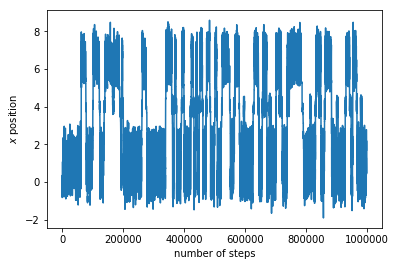

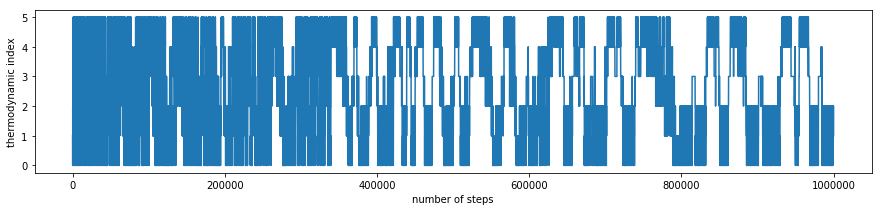

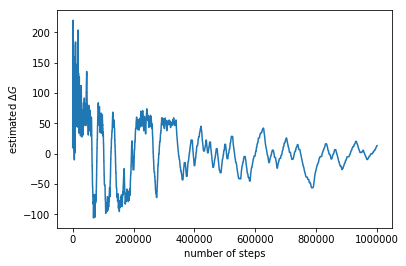

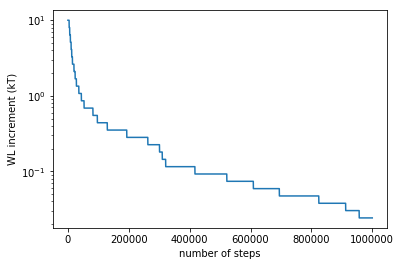

In [13]:
plt.figure()
plt.plot(step_traj, x_traj)
plt.xlabel('number of steps')
plt.ylabel('$x$ position')

plt.figure(figsize=(15,3))
plt.plot(step_traj, i_traj)
plt.xlabel('number of steps')
plt.ylabel('thermodynamic index')

plt.figure()
plt.plot(step_traj, free_energy_traj)
plt.xlabel('number of steps')
plt.ylabel('estimated $\Delta G$')

plt.figure()
plt.plot(step_traj, wl_increment_traj)
plt.yscale('log')
plt.xlabel('number of steps')
plt.ylabel('WL increment (kT)')

dhdl_traj.shape (100000, 6)
i_traj [1 2 2 ... 1 2 1]


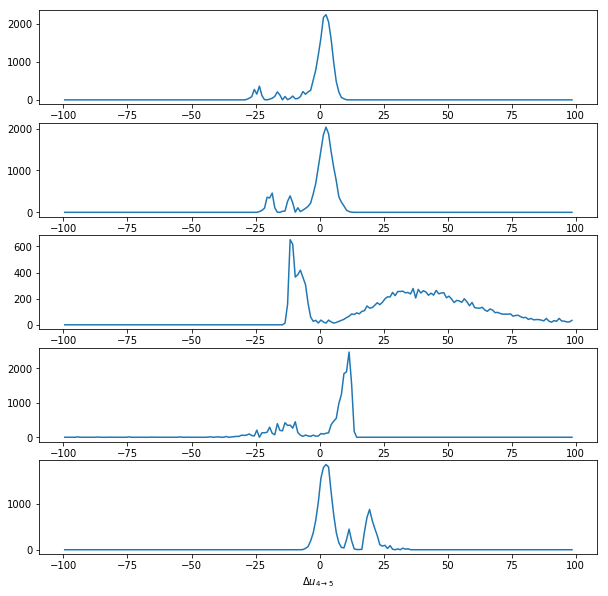

In [17]:
# plot the distribution of the delta_energies 
dhdl_traj = np.array(dhdl_traj)
print('dhdl_traj.shape', dhdl_traj.shape)
i_traj = np.array(i_traj)
print('i_traj', i_traj)

plt.figure(figsize=(10,10))
for j in range(n_ensembles-1):
    
    Ind = (i_traj == j)
    #print('dhdl_traj[Ind,:]', dhdl_traj[Ind,:])
    delta_u = dhdl_traj[Ind, j+1]  # delta_u = (u_{i+1} - u_i) values
    
    delta_u_bins = np.arange(-100., 100., 1.)
    counts, bin_edges = np.histogram(delta_u, bins=delta_u_bins)
    bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0
    
    # Estimate \Delta F as < exp(-\Delta u) >
    dF_estimate = 
    
    plt.subplot(n_ensembles-1, 1, j+1)
    plt.plot(bin_centers, counts)
    plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j,j+1))
    
